In [3]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd 

from tensorflow.keras import datasets, layers, models, regularizers, initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.io import imshow
from skimage.transform import rotate
from skimage.filters.edges import convolve

from skimage.io import imshow, imread
from skimage.transform import resize
from skimage.color import rgb2gray

import dill as pickle

np.random.seed(33)

In [7]:
df_test = pd.read_csv('data/test_labels.csv')
df_train = pd.read_csv('data/train_labels.csv')

bw_loaded = np.load('data/bw_images.npz')
X_train= bw_loaded['a']
X_test = bw_loaded['b']

X_test = X_test.reshape(-1,80,60,1)
X_train = X_train.reshape(-1,80,60,1)

In [8]:
# from model_functions import pick_ylabels, multi_index_counts, test_counts_by_cat, train_counts_by_cat, category_codes, class_weights

In [9]:
def pick_ylabels(column):
    y_train = df_train[column].copy().astype('category').cat.codes
    y_test = df_test[column].copy().astype('category').cat.codes
    return (y_train.values, y_test.values)
def multi_index_counts(col, col2):
    counts = df_test.groupby([col, col2]).count().id
    return counts

def category_codes(column):
    _, ytest = pick_ylabels(column)
    cat_codes = {}
    cat_code_list = []
    for i in range(len(df_test[column].value_counts().index)):
        s = i
        t = df_test[column].value_counts().index[i]
        cat_codes[s] = t
#         cat_code_list.append([s, t])

#     for key in sorted(cat_codes):
#         print("%s: %s" % (key, cat_codes[key]))
    return cat_codes

def test_counts_by_cat(column):
    _, ytest = pick_ylabels(column)
    test_counts_dict = {}
    test_counts = []
    for i in range(len(df_test[column].value_counts().index)):
        s = df_test[column].value_counts().values[i]
        t = df_test[column].value_counts().index[i]
        test_counts_dict[t] = s
        test_counts.append([t, s])
#     for i in sorted(test_counts):
#         print("%s: %s" % (test_counts[0], test_counts[1]))
    return test_counts

def train_counts_by_cat(column):
    y_train = pick_ylabels(column)
    train_counts_dict = {}
    train_counts = []
    for i in range(len(df_test[column].value_counts().index)):
        s = df_train[column].value_counts().values[i]
        t = df_train[column].value_counts().index[i]
        train_counts_dict[t] = s
        train_counts.append([t, s])
#     for i in sorted(test_counts):
#         print("%s: %s" % (test_counts[0], test_counts[1]))
    return test_counts

def class_weights(column):
    train_counts = train_counts_by_cat(column)
    counts_list = []
    ratio_list = []
    ratio_dict = {}
    for x in test_counts:
        counts_list.append(x[1])
    #print(counts_list)
    z = sum(counts_list)
    for x in counts_list:
        if np.round(x/z, 3) ==0:
            ratio_list.append(.001)
        else: 
            ratio_list.append(np.round(x/z, 2))
    for k, v in enumerate(ratio_list):
        ratio_dict[k] = v
    return ratio_dict

def model_results(model, column):
    yhat = model.predict(X_test)
    _ , ytest = pick_ylabels(column)
    accuracy = accuracy_score(ytest, yhat)
    print( 'Accuracy Score: ', accuracy )
    recall = recall_score(ytest, yhat, average='weighted')
    print( 'Recall Score: ', recall)
    y_proba = model.predict_proba(X_test)
    wrong_id_list = []
    pred_cat_list = []
    real_cat_list = []
    for row_idx in range(len(ytest)):
        if ytest[row_idx]!=yhat[row_idx]:
            wrong_id_list.append(row_idx)
            pred_cat_list.append(yhat[row_idx])
            real_cat_list.append(ytest[row_idx])

    arr = np.array([ real_cat_list, pred_cat_list])
    arr = arr.transpose()
    wrong_df = pd.DataFrame( arr, index= wrong_id_list, columns = ['actual', 'predicted'] )
    return (accuracy, recall, wrong_df)

In [10]:
y_train0, y_test0 = pick_ylabels('masterCategory')

In [11]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train0)
y_test = to_categorical(y_test0)

In [12]:
y_train.shape

(25439, 4)

In [15]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

In [20]:
cnn1 = models.Sequential()

In [22]:
cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(80,60,1)))
#MaxPool reduces dimensionality of each feature
cnn1.add(layers.MaxPooling2D((2, 2)))
#Dropout to reduce overfitting
cnn1.add(Dropout(0.25))

cnn1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.25))

cnn1.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# cnn_sub.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.4))

In [23]:
cnn1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 78, 58, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 29, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 13, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 18, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 11, 64)       

In [24]:
cnn1.add(Flatten())

cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dropout(0.3))
cnn1.add(Dense(4, activation='softmax'))

In [25]:
cnn1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
cnn1.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)

Train on 25439 samples, validate on 6440 samples
Epoch 1/10
25439/25439 [==============================] - 30s 1ms/sample - loss: 0.6479 - acc: 0.8152 - val_loss: 0.1586 - val_acc: 0.9488
Epoch 2/10
25439/25439 [==============================] - 30s 1ms/sample - loss: 0.1944 - acc: 0.9350 - val_loss: 0.1110 - val_acc: 0.9641
Epoch 3/10
25439/25439 [==============================] - 40s 2ms/sample - loss: 0.1565 - acc: 0.9494 - val_loss: 0.0872 - val_acc: 0.9742
Epoch 4/10
25439/25439 [==============================] - 40s 2ms/sample - loss: 0.1355 - acc: 0.9543 - val_loss: 0.0813 - val_acc: 0.9748
Epoch 5/10
25439/25439 [==============================] - 40s 2ms/sample - loss: 0.1320 - acc: 0.9585 - val_loss: 0.0828 - val_acc: 0.9755
Epoch 6/10
25439/25439 [==============================] - 39s 2ms/sample - loss: 0.1155 - acc: 0.9634 - val_loss: 0.0697 - val_acc: 0.9801
Epoch 7/10
25439/25439 [==============================] - 39s 2ms/sample - loss: 0.1038 - acc: 0.9672 - val_loss: 0.0

In [27]:
# save the fitted model
cnn1.save('cnn-main.h5')

In [20]:
cnn1 = load_model('cnn-main.h5')

In [21]:
y_true = y_test0

In [22]:
# get the predictions for the test data
predicted_classes = cnn1.predict_classes(X_test)

# get the indices to be plotted
correct = np.nonzero(predicted_classes==y_test0)[0]
incorrect = np.nonzero(predicted_classes!=y_test0)[0]

In [23]:
predicted_classes

array([1, 2, 1, ..., 1, 1, 1])

In [24]:
cat_list = ['Accessories', 'Apparel', 'Footwear', 'Personal Care']
from sklearn.metrics import classification_report
target_names = ["Class {}: {}".format(i, ix) for i, ix in enumerate(cat_list)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

                        precision    recall  f1-score   support

  Class 0: Accessories       0.93      0.98      0.95      1626
      Class 1: Apparel       0.99      0.97      0.98      2603
     Class 2: Footwear       1.00      0.99      0.99      1826
Class 3: Personal Care       0.94      0.93      0.93       385

              accuracy                           0.97      6440
             macro avg       0.96      0.97      0.97      6440
          weighted avg       0.97      0.97      0.97      6440



In [25]:
wrong_arr = np.array([predicted_classes[incorrect], y_test0[incorrect]]).transpose()

In [26]:
wrong_df = pd.DataFrame(wrong_arr, columns=['Predicted','True'])

In [27]:
wrong_df.Predicted.value_counts()

0    117
3     23
1     19
2      8
Name: Predicted, dtype: int64

In [28]:
from sklearn.metrics import multilabel_confusion_matrix
conf = multilabel_confusion_matrix(wrong_arr[:,1], wrong_arr[:,0])
conf.shape

(4, 2, 2)

In [127]:
wrong_df[['True','Predicted']].groupby(['Predicted']).count()

,True
Predicted,
0,117
1,19
2,8
3,23


In [17]:
color_loaded = np.load('data/color_images.npz')
color_test= color_loaded['b']

In [33]:
list_wrong = incorrect
cat_dict = {k:v for k, v in enumerate(cat_list)}

In [34]:
wrong_cat = wrong_df.Predicted.apply(lambda x: cat_dict[x])

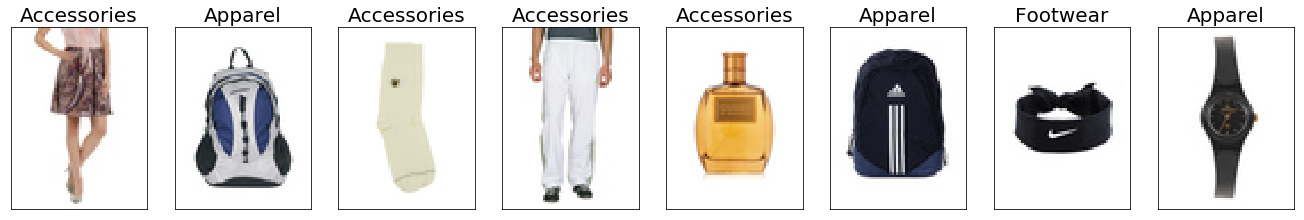

In [47]:
fig, axs = plt.subplots(1, 8, figsize=(23,4))
for i, ax in enumerate(axs.flatten()):
    ax.imshow( color_test[list_wrong[i]].reshape(80,60,3)/255 )
    #print(topwear_idx[i])
    ax.set_xticks([])
    ax.set_yticks([]);
    #ax.set_ylabel('{}')
    ax.set_title('{}'.format(wrong_cat[i]), fontsize=20)
plt.subplots_adjust(hspace = 0.7)

In [63]:
wrong_df[wrong_df.iloc[:,0]==0].iloc[:,1].value_counts()

1    71
3    24
2    22
Name: 1, dtype: int64

In [68]:
wrong_df[wrong_df.iloc[:,0]==1].iloc[:,1].value_counts()

0    16
3     2
2     1
Name: 1, dtype: int64

In [67]:
wrong_df[wrong_df.iloc[:,0]==2].iloc[:,1].value_counts()

0    6
3    1
1    1
Name: 1, dtype: int64

In [69]:
wrong_df[wrong_df.iloc[:,0]==3].iloc[:,1].value_counts()

0    13
1     9
2     1
Name: 1, dtype: int64

In [46]:
arr_wrong = np.array([170,2])
for i in range(len(predicted_classes)):
    if predicted_classes[i]!=y_test0[i]:
        arr_wrong[i,:] = [predicted_classes[i], y_test0[i]]

IndexError: too many indices for array

In [40]:
plt.bar()

TypeError: bar() missing 1 required positional argument: 'height'

In [27]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# gen = ImageDataGenerator(rotation_range=7, width_shift_range=0.05, shear_range=0.05,
#                                height_shift_range=0.05, zoom_range=0.1)
# datagen = gen.flow(X_train, y_train)

In [29]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# gen = ImageDataGenerator(rotation_range=7, width_shift_range=0.05, shear_range=0.05,
#                                height_shift_range=0.05, zoom_range=0.1)
# datagen = gen.flow(X_train, y_train)
# test1 = cnn1.fit_generator(datagen, epochs = 50, use_multiprocessing=True)

In [64]:
last_img = X_test[-1]
last_img = last_img.reshape(-1,80,60,1).astype(np.float32)

In [65]:
layer_output = [last_img.astype(np.float32)]

In [66]:
c = cnn1.layers[0](last_img)
c.numpy().shape

In [ ]:
plt.imshow( c.numpy())

In [36]:
for layer in cnn1.layers:
    output = layer(layer_output[-1])
    layer_output.append( output )

ValueError: Input 0 of layer conv2d is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: [80, 60, 1]

In [ ]:
layer_output[0].shape

nrows, ncols = 5,5
fig, axs = plt.subplots(nrows,ncols,  figsize=(10,10))

for i in range(nrows):
    for j in range(ncols):
        ax = axs[i][j]
        ax.imshow( layer_output[1][0,:,:,i*ncols+j] )
        ax.set_xticks([])
        ax.set_yticks([])

In [ ]:
def model_results(model, column):
    yhat = model.predict(X_test)
    _ , ytest = pick_ylabels(column)
    accuracy = accuracy_score(ytest, yhat)
    print( 'Accuracy Score: ', accuracy )
    recall = recall_score(ytest, yhat, average='weighted')
    print( 'Recall Score: ', recall)
    y_proba = model.predict_proba(X_test)
    wrong_id_list = []
    pred_cat_list = []
    real_cat_list = []
    for row_idx in range(len(ytest)):
        if ytest[row_idx]!=yhat[row_idx]:
            wrong_id_list.append(row_idx)
            pred_cat_list.append(yhat[row_idx])
            real_cat_list.append(ytest[row_idx])

    arr = np.array([ real_cat_list, pred_cat_list])
    arr = arr.transpose()
    wrong_df = pd.DataFrame( arr, index= wrong_id_list, columns = ['actual', 'predicted'] )
    return (accuracy, recall, wrong_df)